In [49]:
import json
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch, torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import pickle

# For plotting
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [50]:
# === Graph Building and Feature Engineering ===

def build_graph_from_json(json_path):
    """
    Builds a heterogeneous graph from a JSON file of safari data.
    The graph contains two types of nodes: 'safari' and 'location'.
    Edges are created between safaris and their locations, and between safaris with shared tags.
    Features are a combination of numerical data, multi-hot encoded tags, and TF-IDF of descriptions.
    """
    def safe_float(val):
        try:
            return float(val.replace('° N','').replace('° S','').replace('° E','').replace('° W','').strip())
        except (ValueError, AttributeError):
            return 0.0
        
    # Add a new safe conversion function for the 'rating' and 'total_reviews' fields.
    def safe_convert(val, type_cast, default_val=0):
        try:
            # Handle 'N/A' and other non-numeric strings
            if isinstance(val, str):
                val = val.replace(',', '')
                if val.strip().lower() == 'n/a':
                    return default_val
            return type_cast(val)
        except (ValueError, AttributeError):
            return default_val

    data = json.load(open(json_path,'r',encoding='utf-8'))

    # Build node lists
    safari_nodes = data
    location_nodes = {}
    for s in safari_nodes:
        location_nodes.setdefault(s['extracted_features']['district'], None)

    # Map nodes to indices
    node_index = {}
    idx = 0
    safari_keys = []
    for s in safari_nodes:
        key = f"SAF:{s.get('id', s['title'])}"
        safari_keys.append(key)
        node_index[key] = idx; idx+=1
    for loc in location_nodes.keys():
        key = f"LOC:{loc}"
        node_index[key] = idx; idx+=1

    # Extract features for safaris
    lat, lon, rating, review_count = [], [], [], []
    descriptions, all_tags = [], []

    for s in safari_nodes:
        lat.append(safe_float(s['extracted_features'].get('latitude', '0')))
        lon.append(safe_float(s['extracted_features'].get('longitude', '0')))

        # Use the new safe_convert function for rating
        rating.append(safe_convert(s.get('rating', 0.0), float))
        
        # Use the new safe_convert function for review_count
        review_count.append(safe_convert(s.get('total_reviews', '0'), int))
        
        descriptions.append(s.get('description',''))
        all_tags.append(s.get('tags', []))

    # Normalize numeric features
    num_feats = np.vstack([lat, lon, rating, np.log1p(review_count)]).T
    scaler = StandardScaler()
    num_feats = scaler.fit_transform(num_feats)

    # Multi-hot encode tags
    # First, collect all unique tags from your full dataset
    all_unique_tags = set(tag for sublist in all_tags for tag in sublist)

    mlb = MultiLabelBinarizer(classes=sorted(list(all_unique_tags)))
    tag_feats = mlb.fit_transform(all_tags)

    # TF-IDF of descriptions
    vect = TfidfVectorizer(max_features=300)
    tfidf = vect.fit_transform(descriptions).toarray()

    # Combine features
    safari_feat = np.hstack([num_feats, tag_feats, tfidf])
    feat_dim = safari_feat.shape[1]

    # Build feature matrix for all nodes
    N = idx
    X = np.zeros((N, feat_dim), dtype=np.float32)
    for i, key in enumerate(safari_keys):
        X[node_index[key]] = safari_feat[i]

    # Location features (mean of safaris at that location)
    for loc in location_nodes.keys():
        key = f"LOC:{loc}"
        saf_idxs = [i for i, s in enumerate(safari_nodes) if s['extracted_features']['district'] == loc]
        if saf_idxs:
            X[node_index[key]] = safari_feat[saf_idxs].mean(axis=0)
        else:
            X[node_index[key]] = np.zeros(feat_dim)

    # Build edges
    edges = []
    for s in safari_nodes:
        s_key = f"SAF:{s.get('id', s['title'])}"
        loc_key = f"LOC:{s['extracted_features']['district']}"
        edges.append((node_index[s_key], node_index[loc_key]))
        edges.append((node_index[loc_key], node_index[s_key])) # bidirectional

    # Safari-safari edges by tag overlap
    for i,s1 in enumerate(safari_nodes):
        for j,s2 in enumerate(safari_nodes[i+1:], start=i+1):
            if s1.get('tags',[]) and s2.get('tags',[]) and set(s1['tags']) & set(s2['tags']):
                a = node_index[f"SAF:{s1.get('id', s1['title'])}"]
                b = node_index[f"SAF:{s2.get('id', s2['title'])}"]
                edges.append((a,b)); edges.append((b,a))

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    X = torch.tensor(X, dtype=torch.float)
    data = Data(x=X, edge_index=edge_index)

    return data, node_index, mlb, vect, scaler, safari_nodes

In [51]:
# === GNN Model and Training ===

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.5)  # <-- ADD THIS LINE

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)  # <-- ADD THIS LINE
        x = self.conv2(x, edge_index)
        return x

def decode(z, edge_index):
    z_src = z[edge_index[0]]
    z_dst = z[edge_index[1]]
    return (z_src * z_dst).sum(dim=1)

def compute_loss(z, edge_label_index, edge_label):
    """
    Computes the loss using the combined positive and negative edge samples
    provided by RandomLinkSplit.
    """
    scores = decode(z, edge_label_index)
    return F.binary_cross_entropy_with_logits(scores, edge_label)

def train_model(data, epochs=100, patience=15):
    """
    Trains the GCNLinkPredictor model for link prediction.
    """
    # Use RandomLinkSplit for train/val/test splits
    transform = RandomLinkSplit(
        num_val=0.1, num_test=0.1, is_undirected=True
    )
    train_data, val_data, test_data = transform(data)

    model = GCNLinkPredictor(data.num_features, hidden_channels=32)
    # To add L2 regularization, change the optimizer in your train_model function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

    # New lists to store metrics
    train_losses, val_losses = [], []
    train_aucs, val_aucs = [], []

    train_fprs, train_tprs, val_fprs, val_tprs = [], [], [], []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None  # <-- ADD THIS LINE to save the best model

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        z = model(train_data.x, train_data.edge_index)

        # The loss function now directly uses edge_label_index and edge_label
        loss = compute_loss(z, train_data.edge_label_index, train_data.edge_label)
        loss.backward()
        optimizer.step()

        # Store training loss
        train_losses.append(loss.item())

        # Intermediate results: calculate and store metrics
        model.eval()
        with torch.no_grad():
            z_train = model(train_data.x, train_data.edge_index)
            train_scores = torch.sigmoid(decode(z_train, train_data.edge_label_index)).cpu().numpy()
            train_labels = train_data.edge_label.cpu().numpy()
            
            z_val = model(val_data.x, val_data.edge_index)
            val_scores = torch.sigmoid(decode(z_val, val_data.edge_label_index)).cpu().numpy()
            val_labels = val_data.edge_label.cpu().numpy()

            # Calculate and store validation loss
            val_loss = compute_loss(z_val, val_data.edge_label_index, val_data.edge_label)
            val_losses.append(val_loss.item())

            # Check if there are both positive and negative samples for AUC calculation
            if len(np.unique(train_labels)) > 1 and len(np.unique(val_labels)) > 1:
                train_auc = roc_auc_score(train_labels, train_scores)
                val_auc = roc_auc_score(val_labels, val_scores)
                train_aucs.append(train_auc)
                val_aucs.append(val_auc)
                print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")

                # Store ROC curve data every 10 epochs
                if epoch % 10 == 0:
                    train_fpr, train_tpr, _ = roc_curve(train_labels, train_scores)
                    val_fpr, val_tpr, _ = roc_curve(val_labels, val_scores)
                    train_fprs.append(train_fpr)
                    train_tprs.append(train_tpr)
                    val_fprs.append(val_fpr)
                    val_tprs.append(val_tpr)
            else:
                train_aucs.append(0.0)  # <-- ADD THIS LINE
                val_aucs.append(0.0)    # <-- ADD THIS LINE
                print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

            # Early Stopping Logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict()  # <-- ADD THIS LINE
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"🛑 Early stopping at epoch {epoch} due to no improvement in validation loss.")
                break

    # Return the new metric lists
    if best_model_state:
        model.load_state_dict(best_model_state)  # <-- ADD THIS LINE

    return model, train_data, val_data, test_data, (train_fprs, train_tprs, val_fprs, val_tprs, train_losses, val_losses, train_aucs, val_aucs)

def save_model_and_artifacts(model, node_index, mlb, vect, scaler, safari_nodes):
    """
    Saves the trained model and other necessary artifacts for future recommendations.
    """
    torch.save(model.state_dict(), 'gnn_model.pt')
    with open('model_artifacts.pkl', 'wb') as f:
        pickle.dump({
            'node_index': node_index,
            'mlb': mlb,
            'vect': vect,
            'scaler': scaler,
            'safari_nodes': safari_nodes
        }, f)
    print("✅ Model and artifacts saved!")

def load_model_and_artifacts(in_channels, hidden_channels):
    """
    Loads the trained model and artifacts from disk.
    """
    model = GCNLinkPredictor(in_channels, hidden_channels)
    model.load_state_dict(torch.load('gnn_model.pt'))
    model.eval()

    with open('model_artifacts.pkl', 'rb') as f:
        artifacts = pickle.load(f)

    return model, artifacts['node_index'], artifacts['mlb'], artifacts['vect'], artifacts['scaler'], artifacts['safari_nodes']


In [52]:

# === Recommendation Generation ===

def get_safari_recommendations(query_text, query_tags, num_recommendations, model, data, artifacts):
    """
    Generates safari recommendations based on a user query.
    """
    node_index = artifacts['node_index']
    mlb = artifacts['mlb']
    vect = artifacts['vect']
    scaler = artifacts['scaler']
    safari_nodes = artifacts['safari_nodes']

    # Get embeddings for all nodes in the graph
    with torch.no_grad():
        all_node_embeddings = model(data.x, data.edge_index)

    # Create a feature vector for the user query
    query_description_tfidf = vect.transform([query_text]).toarray()
    known_tags = [tag for tag in query_tags if tag in mlb.classes_]
    query_tags_mlb = mlb.transform([known_tags])
    
    # Placeholder for numerical features
    query_num_feats = scaler.transform(np.array([[0, 0, 0, 0]])) 
    
    query_features = np.hstack([query_num_feats, query_tags_mlb, query_description_tfidf])
    query_features_tensor = torch.tensor(query_features, dtype=torch.float)

    # Generate an embedding for the query using the GCN model
    # We pass an empty edge_index because the query is a single, isolated node
    query_embedding = model(query_features_tensor, torch.empty((2, 0), dtype=torch.long))

    # Get embeddings only for safari nodes
    safari_keys = [key for key in node_index.keys() if key.startswith("SAF:")]
    safari_indices = [node_index[key] for key in safari_keys]
    
    safari_embeddings = all_node_embeddings[safari_indices]

    # Calculate similarity between the query embedding and all safari embeddings
    similarities = F.cosine_similarity(query_embedding, safari_embeddings)

    # Get top recommendations
    top_indices = torch.topk(similarities, k=num_recommendations).indices.tolist()
    
    recommended_safaris = [safari_nodes[i] for i in top_indices]
    
    return recommended_safaris

--- 1. Building the graph and extracting features ---

--- 2. Training the model and saving artifacts ---
Epoch 001, Loss: 0.5280, Train AUC: 0.9960, Val AUC: 0.9959
Epoch 002, Loss: 0.4677, Train AUC: 0.9987, Val AUC: 0.9995
Epoch 003, Loss: 0.4484, Train AUC: 0.9987, Val AUC: 0.9994
Epoch 004, Loss: 0.4439, Train AUC: 0.9987, Val AUC: 0.9956
Epoch 005, Loss: 0.4345, Train AUC: 0.9987, Val AUC: 0.9942
Epoch 006, Loss: 0.4158, Train AUC: 0.9985, Val AUC: 0.9945
Epoch 007, Loss: 0.4127, Train AUC: 0.9981, Val AUC: 0.9946
Epoch 008, Loss: 0.4178, Train AUC: 0.9982, Val AUC: 0.9950
Epoch 009, Loss: 0.4476, Train AUC: 0.9979, Val AUC: 0.9990
Epoch 010, Loss: 0.4041, Train AUC: 0.9979, Val AUC: 0.9988
Epoch 011, Loss: 0.3990, Train AUC: 0.9979, Val AUC: 0.9988
Epoch 012, Loss: 0.4106, Train AUC: 0.9981, Val AUC: 0.9993
Epoch 013, Loss: 0.4097, Train AUC: 0.9982, Val AUC: 0.9994
Epoch 014, Loss: 0.3942, Train AUC: 0.9983, Val AUC: 0.9996
Epoch 015, Loss: 0.3931, Train AUC: 0.9983, Val AUC: 0

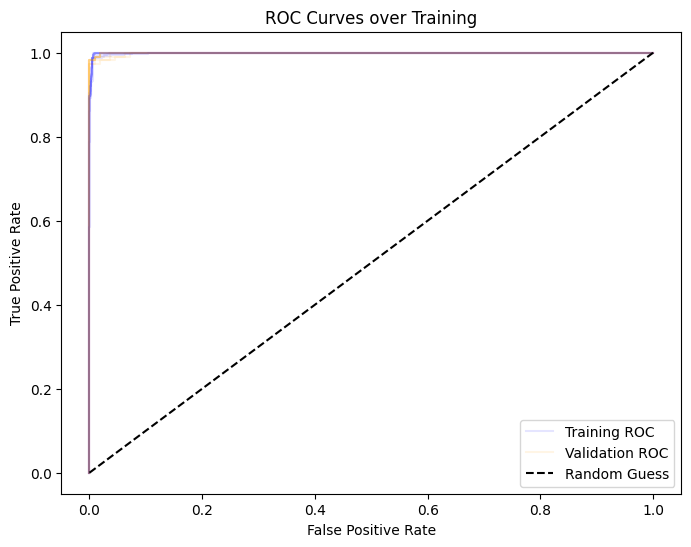


--- 2.2 Plotting Loss and AUC Curves ---


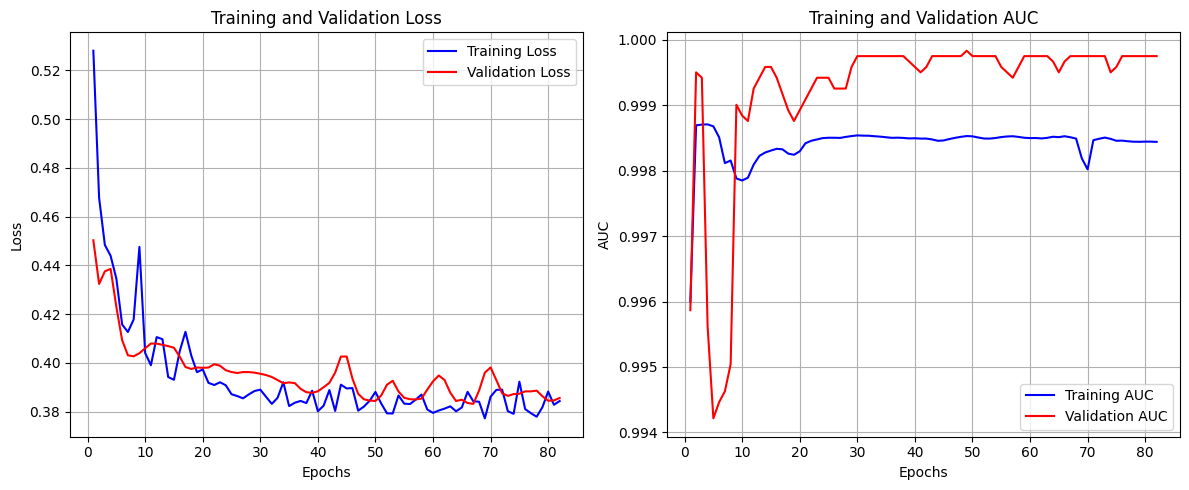


--- 3. Visualizing the Graph ---


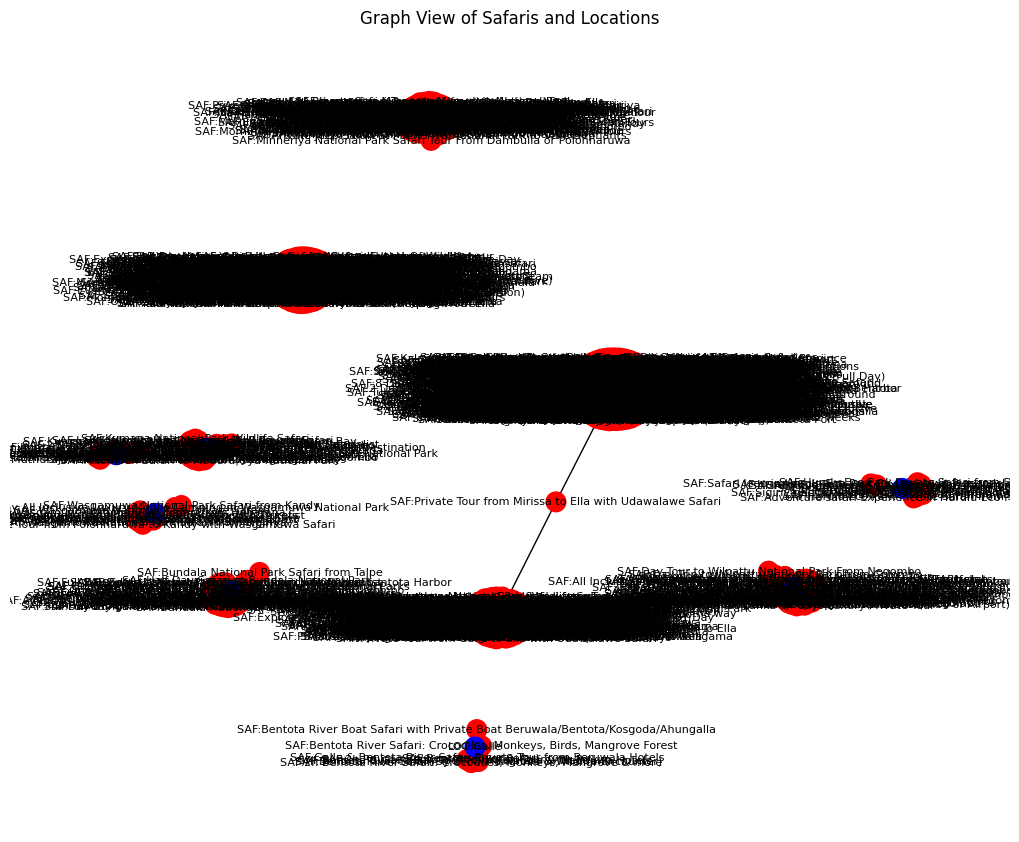


--- Recommendations for your query ---
1. All Inclusive Wilpattu National Park Safari Day Tour from Colombo & Negombo (Rating: N/A)
2. Udawalawe Jeep Safari from Kalutara & Wadduwa Hotels (Rating: N/A)
3. Full Day Shared Safari at Yala National Park by La Safari Inn Tours (Rating: N/A)
4. Hurulu Eco Park Safari from Polonnaruwa (Rating: N/A)
5. Full day / Half Day WildlifeAdventure in Yala-National-Park (Rating: 4.9)


C:\Users\thara\AppData\Local\Temp\ipykernel_20828\1307537896.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gnn_model.pt'))


In [53]:

# === Main Execution ===
if __name__ == "__main__":
    json_path = "sri_lanka_safari_feature_extracted.json"
    
    # 1. Build the graph and extract features
    print("--- 1. Building the graph and extracting features ---")
    data, node_index, mlb, vect, scaler, safari_nodes = build_graph_from_json(json_path)

    # 2. Train the model and save artifacts
    print("\n--- 2. Training the model and saving artifacts ---")
    model, _, val_data, _, (train_fprs, train_tprs, val_fprs, val_tprs, train_losses, val_losses, train_aucs, val_aucs) = train_model(data, epochs=100, patience=15)
    save_model_and_artifacts(model, node_index, mlb, vect, scaler, safari_nodes)

    # 2.1 Plotting ROC curves
    print("\n--- 2.1 Plotting ROC Curves ---")
    plt.figure(figsize=(8, 6))
    for i in range(len(train_fprs)):
        plt.plot(train_fprs[i], train_tprs[i], color='blue', alpha=0.1, label='Training ROC' if i == 0 else "")
        plt.plot(val_fprs[i], val_tprs[i], color='orange', alpha=0.1, label='Validation ROC' if i == 0 else "")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves over Training')
    plt.legend()
    plt.show()

    # New: 2.2 Plotting Loss and AUC curves
    print("\n--- 2.2 Plotting Loss and AUC Curves ---")
    plot_metrics(train_losses, val_losses, train_aucs, val_aucs)

    print("\n--- 3. Visualizing the Graph ---")
    G = nx.Graph()
    for i, (key, idx) in enumerate(node_index.items()):
        G.add_node(idx, label=key, node_type=key.split(':')[0])

    for i in range(data.edge_index.size(1)):
        source, target = data.edge_index[0, i].item(), data.edge_index[1, i].item()
        G.add_edge(source, target)

    pos = nx.spring_layout(G)
    node_colors = ['red' if G.nodes[node]['node_type'] == 'SAF' else 'blue' for node in G.nodes]
    node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
    
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=200, font_size=8)
    plt.title('Graph View of Safaris and Locations')
    plt.show()

    # 3. Load the model and artifacts
    loaded_model, loaded_node_index, loaded_mlb, loaded_vect, loaded_scaler, loaded_safari_nodes = load_model_and_artifacts(data.num_features, hidden_channels=32)
    
    # 4. Generate recommendations for a sample query
    query_text = "elephant watching"
    query_tags = ["Elephants"]
    num_recommendations = 5
    
    recommendations = get_safari_recommendations(
        query_text, 
        query_tags, 
        num_recommendations, 
        loaded_model, 
        data, # Pass the data object here
        {'node_index': loaded_node_index, 'mlb': loaded_mlb, 'vect': loaded_vect, 'scaler': loaded_scaler, 'safari_nodes': loaded_safari_nodes}
    )
    
    print("\n--- Recommendations for your query ---")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} (Rating: {rec['rating']})")


--- 2.2 Plotting Loss and AUC Curves ---


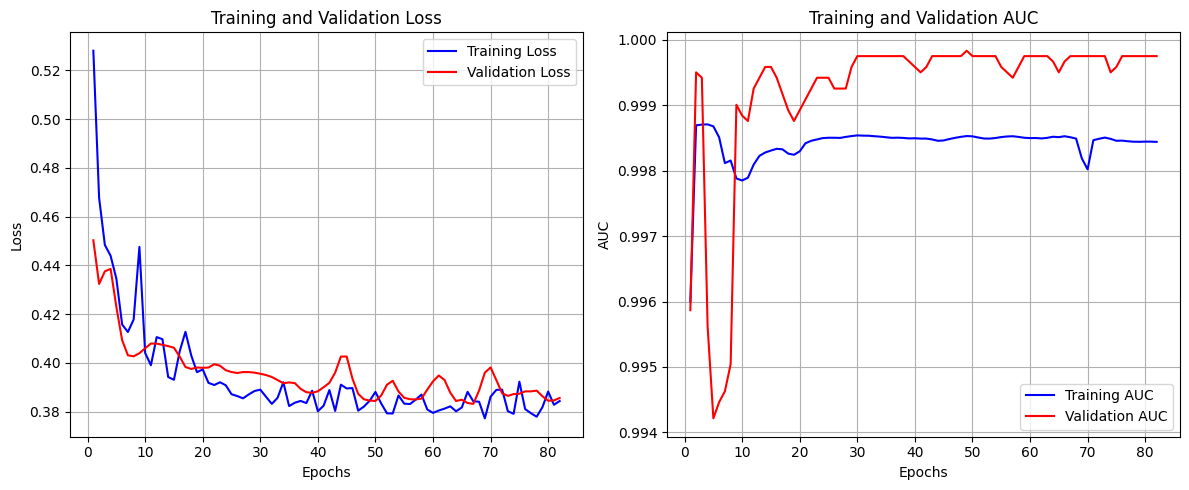

In [54]:
# B6
# === Plotting Functions ===

def plot_metrics(train_losses, val_losses, train_aucs, val_aucs):
    """
    Plots the training and validation loss and AUC over epochs.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot AUC Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_aucs, 'b-', label='Training AUC')
    plt.plot(epochs, val_aucs, 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# === Main Execution (Update) ===
# This section will be added to the if __name__ == "__main__": block
# after the training and plotting of ROC curves.

# 2.2 Plotting Loss and AUC curves
print("\n--- 2.2 Plotting Loss and AUC Curves ---")
plot_metrics(train_losses, val_losses, train_aucs, val_aucs)

In [55]:
# 4. Generate recommendations for a sample query
query_text = "leopards"
query_tags = ["leopards"]
num_recommendations = 5
    
recommendations = get_safari_recommendations(
    query_text, 
    query_tags, 
    num_recommendations, 
    loaded_model, 
    data, # Pass the data object here
    {'node_index': loaded_node_index, 'mlb': loaded_mlb, 'vect': loaded_vect, 'scaler': loaded_scaler, 'safari_nodes': loaded_safari_nodes}
)
    
print("\n--- Recommendations for your query ---")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (Rating: {rec['rating']})")


--- Recommendations for your query ---
1. All Inclusive Wilpattu National Park Safari Day Tour from Colombo & Negombo (Rating: N/A)
2. Udawalawe Jeep Safari from Kalutara & Wadduwa Hotels (Rating: N/A)
3. Full Day Shared Safari at Yala National Park by La Safari Inn Tours (Rating: N/A)
4. Hurulu Eco Park Safari from Polonnaruwa (Rating: N/A)
5. Full day / Half Day WildlifeAdventure in Yala-National-Park (Rating: 4.9)
